In [18]:
import os
import time
from datetime import datetime
import xarray as xr
import numpy as np
import pandas as pd
from concurrent.futures import ProcessPoolExecutor
from scipy.signal import butter, filtfilt

# Define the Butterworth bandpass filter
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data, axis=0)
    return y

def interpolate_nan(data):
    """Interpolate NaNs in the data."""
    nans, x = np.isnan(data), lambda z: z.nonzero()[0]
    data[nans] = np.interp(x(nans), x(~nans), data[~nans])
    return data

def find_nearest_non_nan(dataset, lat_idx, lon_idx):
    """Find the nearest non-NaN value in the dataset around the given indices."""
    max_radius = 5  # Define the maximum search radius
    for radius in range(1, max_radius + 1):
        for dlat in range(-radius, radius + 1):
            for dlon in range(-radius, radius + 1):
                if abs(dlat) == radius or abs(dlon) == radius:
                    new_lat_idx = lat_idx + dlat
                    new_lon_idx = lon_idx + dlon
                    if (0 <= new_lat_idx < dataset.dims['latitude']) and (0 <= new_lon_idx < dataset.dims['longitude']):
                        sla_data_point = dataset['sla'].isel(latitude=new_lat_idx, longitude=new_lon_idx).values.item()
                        if not np.isnan(sla_data_point):
                            return sla_data_point
    return np.nan

# Define the vertices of the parallelogram for EAST_AUSTRALIA
parallelogram_vertices = np.array([
    [149, -38],  # Bottom-left
    [158, -38],  # Bottom-right
    [158, -25],  # Top-right
    [149, -25]   # Top-left
])

# Check if a point is inside the parallelogram
def is_inside_parallelogram(lat_grid, lon_grid, vertices):
    # Mask for points inside the bounding box (min/max lat/lon)
    mask_lon = (lon_grid >= vertices[:, 0].min()) & (lon_grid <= vertices[:, 0].max())
    mask_lat = (lat_grid >= vertices[:, 1].min()) & (lat_grid <= vertices[:, 1].max())
    return mask_lon & mask_lat

# Function to process each valid point and save to NetCDF in parallel
def process_grid_point(latitude, longitude, date_file_list, lowcut, highcut, fs, output_dir):
    sla_data = []
    date_list = []

    for file_date, file_path in date_file_list:
        dataset = xr.open_dataset(file_path)
        
        # Find nearest indices to the specified latitude and longitude
        lat_idx = abs(dataset.latitude - latitude).argmin()
        lon_idx = abs(dataset.longitude - longitude).argmin()

        # Extract SLA at the specified point
        sla_data_point = dataset['sla'].isel(latitude=lat_idx, longitude=lon_idx).values.item()

        # Only proceed if the SLA point is non-NaN
        if not np.isnan(sla_data_point):
            sla_data.append(sla_data_point)
            date_list.append(file_date)
        else:
            # Attempt to find a nearby non-NaN value
            sla_data_point = find_nearest_non_nan(dataset, lat_idx, lon_idx)
            if not np.isnan(sla_data_point):
                sla_data.append(sla_data_point)
                date_list.append(file_date)

        dataset.close()

    if not sla_data:  # If no valid data collected, return NaN-filled arrays
        return latitude, longitude, np.nan, np.nan

    # Convert the list to xarray DataArray with time dimension
    time_index = pd.to_datetime(date_list)
    sla_time_series_da = xr.DataArray(sla_data, dims=['time'], coords={'time': time_index})

    # Apply the Butterworth bandpass filter if valid
    series = sla_time_series_da.values
    nan_count = np.isnan(series).sum()

    if nan_count <= 0.9 * len(sla_time_series_da.time):
        if nan_count > 0:
            series = interpolate_nan(series)  # Interpolate NaNs
        filtered_series = butter_bandpass_filter(series, lowcut, highcut, fs, order=5)
    else:
        filtered_series = np.full_like(series, np.nan)  # Create NaN-filled array

    # Save results to NetCDF
    save_to_netcdf(latitude, longitude, sla_time_series_da, filtered_series, output_dir)

    return latitude, longitude, series, filtered_series

def save_to_netcdf(lat, lon, unfiltered_series, filtered_series, output_dir):
    """Save the unfiltered and filtered series to NetCDF format."""
    file_name = f"filtered_sla_lat_{lat:.2f}_lon_{lon:.2f}.nc"
    output_path = os.path.join(output_dir, file_name)

    # Create a dataset with unfiltered and filtered SLA data
    ds = xr.Dataset(
        {
            "unfiltered_sla": xr.DataArray(unfiltered_series.values, dims=["time"], coords={"time": unfiltered_series.time}),
            "filtered_sla": xr.DataArray(filtered_series, dims=["time"], coords={"time": unfiltered_series.time})
        },
        coords={"latitude": lat, "longitude": lon}
    )

    # Save to NetCDF format
    ds.to_netcdf(output_path)
    print(f"Saved {output_path}")

# Main processing function
def main():
    # Load the dataset for 2023
    base_dir = '/DGFI8/D/SWOT_L4/SWOT_Daily_Product_L4'
    output_dir = '/nfs/DGFI8/H/work_marcello/coastal_trapped_waves_data/filtered_grids_SWOT'
    os.makedirs(output_dir, exist_ok=True)  # Ensure output directory exists

    sample_file_path = os.path.join(base_dir, os.listdir(base_dir)[0])  # Get the first file
    sample_dataset = xr.open_dataset(sample_file_path)

    latitudes = sample_dataset.latitude.values
    longitudes = sample_dataset.longitude.values

    # Create 2D grids of lat/lon using meshgrid
    lat_grid, lon_grid = np.meshgrid(latitudes, longitudes)

    # Get the mask for valid grid points within the parallelogram
    mask = is_inside_parallelogram(lat_grid, lon_grid, parallelogram_vertices)
    valid_lats = lat_grid[mask]
    valid_lons = lon_grid[mask]

    # Collect all NetCDF file paths and dates
    date_file_list = []
    start_date = datetime(2023, 8, 29)
    end_date = datetime(2023, 11, 30)
    for file_name in os.listdir(base_dir):
        if file_name.endswith('.nc'):
            file_date_str = file_name.split('_')[-2]
            file_date = datetime.strptime(file_date_str, "%Y%m%d")
            if start_date <= file_date <= end_date:
                file_path = os.path.join(base_dir, file_name)
                date_file_list.append((file_date, file_path))

    date_file_list.sort()

    # Limit the number of points to process (test with a successful output of 100)
    max_successful_files = 100
    successful_files_count = 0

    # Use a ProcessPoolExecutor to parallelize processing for each valid grid point
    with ProcessPoolExecutor() as executor:
        futures = []
        for latitude, longitude in zip(valid_lats, valid_lons):
            # Only submit tasks for valid grid points that are non-NaN in the original grid
            if successful_files_count >= max_successful_files:
                break

            # Check if the SLA data point is non-NaN in the first sample dataset
            lat_idx = abs(sample_dataset.latitude - latitude).argmin()
            lon_idx = abs(sample_dataset.longitude - longitude).argmin()
            sla_data_point = sample_dataset['sla'].isel(latitude=lat_idx, longitude=lon_idx).values.item()
            
            if not np.isnan(sla_data_point):
                futures.append(executor.submit(process_grid_point, latitude, longitude, date_file_list, lowcut, highcut, fs, output_dir))
                successful_files_count += 1

        # Retrieve results and print summary for the first few points
        for future in futures:
            latitude, longitude, unfiltered, filtered = future.result()
            print(f"Processed point at lat: {latitude}, lon: {longitude}")

if __name__ == '__main__':
    # Define the frequency cutoffs for the filter
    lowcut = 0.035  # Lower cutoff in cycles per day
    highcut = 0.15  # Upper cutoff in cycles per day
    fs = 1.0  # Sampling frequency in cycles per day

    # Start a timer to measure performance
    start_time = time.time()
    main()  # Call the main processing function
    end_time = time.time()
    print(f"Processing completed in {end_time - start_time:.2f} seconds.")


Saved /nfs/DGFI8/H/work_marcello/coastal_trapped_waves_data/filtered_grids_SWOT/filtered_sla_lat_-38.00_lon_149.00.ncSaved /nfs/DGFI8/H/work_marcello/coastal_trapped_waves_data/filtered_grids_SWOT/filtered_sla_lat_-37.80_lon_149.00.nc

Saved /nfs/DGFI8/H/work_marcello/coastal_trapped_waves_data/filtered_grids_SWOT/filtered_sla_lat_-37.90_lon_149.10.nc
Processed point at lat: -38.0, lon: 149.0
Saved /nfs/DGFI8/H/work_marcello/coastal_trapped_waves_data/filtered_grids_SWOT/filtered_sla_lat_-38.00_lon_149.10.nc
Saved /nfs/DGFI8/H/work_marcello/coastal_trapped_waves_data/filtered_grids_SWOT/filtered_sla_lat_-37.90_lon_149.00.nc
Saved /nfs/DGFI8/H/work_marcello/coastal_trapped_waves_data/filtered_grids_SWOT/filtered_sla_lat_-37.80_lon_149.10.nc
Processed point at lat: -37.900001525878906, lon: 149.0
Processed point at lat: -37.79999923706055, lon: 149.0
Processed point at lat: -38.0, lon: 149.1
Processed point at lat: -37.900001525878906, lon: 149.1
Processed point at lat: -37.7999992370605

Saved /nfs/DGFI8/H/work_marcello/coastal_trapped_waves_data/filtered_grids_SWOT/filtered_sla_lat_-37.10_lon_150.00.nc
Processed point at lat: -37.099998474121094, lon: 150.0
Saved /nfs/DGFI8/H/work_marcello/coastal_trapped_waves_data/filtered_grids_SWOT/filtered_sla_lat_-36.90_lon_150.00.nc
Saved /nfs/DGFI8/H/work_marcello/coastal_trapped_waves_data/filtered_grids_SWOT/filtered_sla_lat_-37.00_lon_150.00.nc
Saved /nfs/DGFI8/H/work_marcello/coastal_trapped_waves_data/filtered_grids_SWOT/filtered_sla_lat_-36.80_lon_150.00.nc
Processed point at lat: -37.0, lon: 150.0
Processed point at lat: -36.900001525878906, lon: 150.0
Processed point at lat: -36.79999923706055, lon: 150.0
Saved /nfs/DGFI8/H/work_marcello/coastal_trapped_waves_data/filtered_grids_SWOT/filtered_sla_lat_-36.70_lon_150.00.nc
Saved /nfs/DGFI8/H/work_marcello/coastal_trapped_waves_data/filtered_grids_SWOT/filtered_sla_lat_-38.00_lon_150.10.nc
Processed point at lat: -36.70000076293945, lon: 150.0
Processed point at lat: -38.

Saved /nfs/DGFI8/H/work_marcello/coastal_trapped_waves_data/filtered_grids_SWOT/filtered_sla_lat_-37.80_lon_150.30.nc
Saved /nfs/DGFI8/H/work_marcello/coastal_trapped_waves_data/filtered_grids_SWOT/filtered_sla_lat_-37.70_lon_150.30.nc
Processed point at lat: -37.79999923706055, lon: 150.3
Processed point at lat: -37.70000076293945, lon: 150.3
Saved /nfs/DGFI8/H/work_marcello/coastal_trapped_waves_data/filtered_grids_SWOT/filtered_sla_lat_-37.60_lon_150.30.nc
Saved /nfs/DGFI8/H/work_marcello/coastal_trapped_waves_data/filtered_grids_SWOT/filtered_sla_lat_-37.50_lon_150.30.nc
Processed point at lat: -37.599998474121094, lon: 150.3
Processed point at lat: -37.5, lon: 150.3
Saved /nfs/DGFI8/H/work_marcello/coastal_trapped_waves_data/filtered_grids_SWOT/filtered_sla_lat_-37.40_lon_150.30.nc
Saved /nfs/DGFI8/H/work_marcello/coastal_trapped_waves_data/filtered_grids_SWOT/filtered_sla_lat_-37.30_lon_150.30.nc
Processed point at lat: -37.400001525878906, lon: 150.3
Processed point at lat: -37.

In [22]:
import os
import xarray as xr
import numpy as np
import pandas as pd
from datetime import datetime
import time

# Function to check if a point is inside the parallelogram
def is_inside_parallelogram(lat, lon, vertices):
    """
    Check if a point (lat, lon) is inside the defined parallelogram
    """
    if lon < np.min(vertices[:, 0]) or lon > np.max(vertices[:, 0]):
        return False
    if lat < np.min(vertices[:, 1]) or lat > np.max(vertices[:, 1]):
        return False
    return True

# Function to reconstruct daily grids from filtered time series
def reconstruct_daily_grids(input_dir, original_grid_file, output_dir, start_date, end_date, parallelogram_vertices, test_days=5):
    """
    Rebuild daily grids from saved time series of each grid point.

    Parameters:
    - input_dir: Directory where the time series for each grid point is stored.
    - original_grid_file: Path to a sample original NetCDF file for structure.
    - output_dir: Directory where the reconstructed daily grids will be saved.
    - start_date: Start date for reconstruction (datetime).
    - end_date: End date for reconstruction (datetime).
    - parallelogram_vertices: Array defining the vertices of the parallelogram for spatial filtering.
    - test_days: Number of days to process for testing purposes.
    """
    # Start a timer to measure performance
    start_time = time.time()
    
    # Load the original grid to get the spatial structure (lat/lon dimensions)
    original_dataset = xr.open_dataset(original_grid_file)
    latitudes = original_dataset.latitude.values
    longitudes = original_dataset.longitude.values

    # Filter latitudes and longitudes based on the parallelogram
    lat_indices, lon_indices = [], []
    for lat_idx, lat in enumerate(latitudes):
        for lon_idx, lon in enumerate(longitudes):
            if is_inside_parallelogram(lat, lon, parallelogram_vertices):
                lat_indices.append(lat_idx)
                lon_indices.append(lon_idx)

    # Reduce latitudes and longitudes to the region of interest
    valid_latitudes = latitudes[np.unique(lat_indices)]
    valid_longitudes = longitudes[np.unique(lon_indices)]

    # Create a time range for the target dates
    time_range = pd.date_range(start=start_date, end=end_date, freq='D')

    # Limit the time range to the specified number of test days
    time_range = time_range[:test_days]

    # Ensure output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Initialize a dictionary to store all the time series data
    time_series_data = {}

    # Load all time series files (assuming format filtered_sla_lat_xx_lon_xx.nc) from input directory
    for file_name in os.listdir(input_dir):
        if file_name.startswith('filtered_sla') and file_name.endswith('.nc'):
            lat_lon_str = file_name.replace('filtered_sla_lat_', '').replace('.nc', '')
            lat_str, lon_str = lat_lon_str.split('_lon_')
            lat, lon = float(lat_str), float(lon_str)

            # Load the time series for this grid point
            ds = xr.open_dataset(os.path.join(input_dir, file_name))
            time_series_data[(lat, lon)] = ds['filtered_sla'].values
            ds.close()

    # For each day in the range, reconstruct the grid and save as NetCDF
    for day in time_range:
        print(f"Reconstructing grid for {day}")

        # Initialize an empty array for the grid (valid lat, valid lon)
        grid = np.full((len(valid_latitudes), len(valid_longitudes)), np.nan)

        # Iterate over each valid grid point and assign the value for the current day
        for lat_idx, lat in enumerate(valid_latitudes):
            for lon_idx, lon in enumerate(valid_longitudes):
                if (lat, lon) in time_series_data:
                    # Find the corresponding value for the current day
                    try:
                        day_index = np.where(ds.time == np.datetime64(day))[0][0]
                        grid[lat_idx, lon_idx] = time_series_data[(lat, lon)][day_index]
                    except IndexError:
                        # In case the day doesn't exist in the time series, leave as NaN
                        pass

        # Create a new dataset for the current day
        filtered_dataset = xr.Dataset(
            {
                'sla': (['latitude', 'longitude'], grid)
            },
            coords={
                'latitude': valid_latitudes,
                'longitude': valid_longitudes,
                'time': pd.to_datetime([day])
            }
        )

        # Save the reconstructed grid for this day
        output_file = os.path.join(output_dir, f"filtered_grid_{day.strftime('%Y%m%d')}.nc")
        filtered_dataset.to_netcdf(output_file)
        print(f"Saved reconstructed grid for {day} to {output_file}")

    original_dataset.close()

    # End the timer and print the total processing time
    end_time = time.time()
    total_time = end_time - start_time
    print(f"Total processing time for reconstruction: {total_time:.2f} seconds")

# Main function to drive the reconstruction process
def main():
    input_dir = '/nfs/DGFI8/H/work_marcello/coastal_trapped_waves_data/filtered_grids_SWOT'
    output_dir = '/nfs/DGFI8/H/work_marcello/coastal_trapped_waves_data/filtered_daily_grids_SWOT_reconstructed'
    
    # Dynamically select any original grid file from the specified directory
    original_grid_dir = '/DGFI8/D/SWOT_L4/SWOT_Daily_Product_L4'
    original_grid_files = [f for f in os.listdir(original_grid_dir) if f.endswith('.nc')]
    
    if not original_grid_files:
        raise FileNotFoundError("No original grid files found in the specified directory.")

    original_grid_file = os.path.join(original_grid_dir, original_grid_files[0])  # Use the first file found
    print(f"Using original grid file: {original_grid_file}")

    start_date = datetime(2023, 8, 29)
    end_date = datetime(2023, 11, 30)

    # Define the vertices of the parallelogram (EAST_AUSTRALIA region)
    parallelogram_vertices = np.array([
        [149, -38],  # Bottom-left
        [158, -38],  # Bottom-right
        [158, -25],  # Top-right
        [149, -25]   # Top-left
    ])

    # Run reconstruction with a limit on the number of days to process
    reconstruct_daily_grids(input_dir, original_grid_file, output_dir, start_date, end_date, parallelogram_vertices, test_days=5)

if __name__ == "__main__":
    main()


Using original grid file: /DGFI8/D/SWOT_L4/SWOT_Daily_Product_L4/dt_global_allsat_phy_l4_20230501_20240501.nc
Reconstructing grid for 2023-08-29 00:00:00
Saved reconstructed grid for 2023-08-29 00:00:00 to /nfs/DGFI8/H/work_marcello/coastal_trapped_waves_data/filtered_daily_grids_SWOT_reconstructed/filtered_grid_20230829.nc
Reconstructing grid for 2023-08-30 00:00:00
Saved reconstructed grid for 2023-08-30 00:00:00 to /nfs/DGFI8/H/work_marcello/coastal_trapped_waves_data/filtered_daily_grids_SWOT_reconstructed/filtered_grid_20230830.nc
Reconstructing grid for 2023-08-31 00:00:00
Saved reconstructed grid for 2023-08-31 00:00:00 to /nfs/DGFI8/H/work_marcello/coastal_trapped_waves_data/filtered_daily_grids_SWOT_reconstructed/filtered_grid_20230831.nc
Reconstructing grid for 2023-09-01 00:00:00
Saved reconstructed grid for 2023-09-01 00:00:00 to /nfs/DGFI8/H/work_marcello/coastal_trapped_waves_data/filtered_daily_grids_SWOT_reconstructed/filtered_grid_20230901.nc
Reconstructing grid for 20

Selected file: filtered_sla_lat_-37.90_lon_149.40.nc


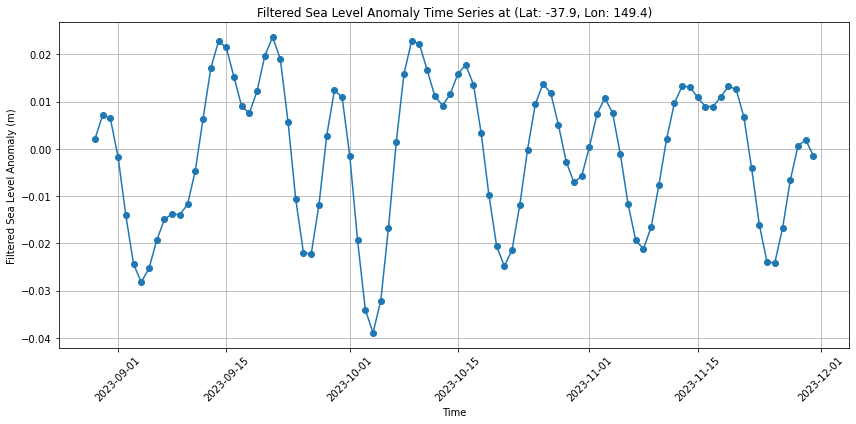

In [21]:
import os
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import random
import re

# Function to plot a filtered time series for a specific grid point
def plot_filtered_time_series(input_dir, latitude, longitude):
    """
    Plot the filtered time series for a specific latitude and longitude.

    Parameters:
    - input_dir: Directory containing the filtered time series files.
    - latitude: Latitude of the grid point to plot.
    - longitude: Longitude of the grid point to plot.
    """
    # Construct the filename based on the latitude and longitude
    lat_str = f"{latitude:.2f}"
    lon_str = f"{longitude:.2f}"
    file_name = f"filtered_sla_lat_{lat_str}_lon_{lon_str}.nc"
    file_path = os.path.join(input_dir, file_name)

    # Check if the file exists
    if not os.path.isfile(file_path):
        print(f"File not found: {file_path}")
        return

    # Load the filtered time series dataset
    dataset = xr.open_dataset(file_path)

    # Extract the time series data
    time_series = dataset['filtered_sla'].values  # Ensure this matches your variable name
    time = dataset['time'].values

    # Close the dataset after loading the data
    dataset.close()

    # Plot the time series
    plt.figure(figsize=(12, 6))
    plt.plot(time, time_series, marker='o', linestyle='-')
    plt.title(f'Filtered Sea Level Anomaly Time Series at (Lat: {latitude}, Lon: {longitude})')
    plt.xlabel('Time')
    plt.ylabel('Filtered Sea Level Anomaly (m)')
    plt.xticks(rotation=45)
    plt.grid()
    plt.tight_layout()
    plt.show()

# Function to randomly select a file and plot the corresponding time series
def plot_random_filtered_time_series(input_dir):
    """
    Randomly select a filtered time series file and plot its data.

    Parameters:
    - input_dir: Directory containing the filtered time series files.
    """
    # List all NetCDF files in the input directory
    filtered_files = [f for f in os.listdir(input_dir) if f.endswith('.nc')]

    # Check if there are any filtered files
    if not filtered_files:
        print("No filtered files found in the directory.")
        return

    # Randomly select a file
    selected_file = random.choice(filtered_files)
    print(f"Selected file: {selected_file}")

    # Use regex to extract latitude and longitude from the filename
    match = re.search(r'lat_([-+]?\d*\.\d+|[-+]?\d+)_lon_([-+]?\d*\.\d+|[-+]?\d+)', selected_file)
    if match:
        latitude = float(match.group(1))
        longitude = float(match.group(2))
    else:
        print("Could not extract latitude and longitude from the filename.")
        return

    # Call the plotting function with the selected latitude and longitude
    plot_filtered_time_series(input_dir, latitude, longitude)

# Example usage
input_dir = '/nfs/DGFI8/H/work_marcello/coastal_trapped_waves_data/filtered_grids_SWOT'

# Call the function to plot a random filtered time series
plot_random_filtered_time_series(input_dir)


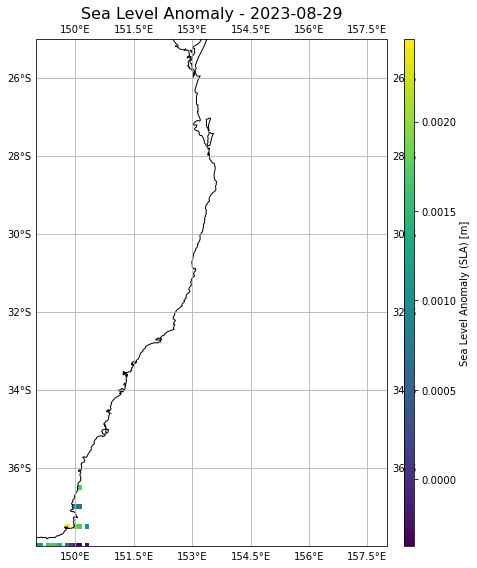

In [23]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np

def plot_reconstructed_grid(nc_file):
    # Load the dataset
    dataset = xr.open_dataset(nc_file)

    # Extract the data for plotting
    grid_data = dataset['sla'].values
    latitudes = dataset['latitude'].values
    longitudes = dataset['longitude'].values
    time = dataset['time'].values

    # Create a map with Cartopy
    fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})
    ax.set_extent([longitudes.min(), longitudes.max(), latitudes.min(), latitudes.max()], crs=ccrs.PlateCarree())

    # Add coastlines and gridlines
    ax.coastlines()
    ax.gridlines(draw_labels=True)

    # Plot the data
    im = ax.pcolormesh(longitudes, latitudes, grid_data, shading='auto', cmap='viridis', transform=ccrs.PlateCarree())
    
    # Add a colorbar
    cbar = plt.colorbar(im, ax=ax, orientation='vertical', pad=0.02, aspect=50)
    cbar.set_label('Sea Level Anomaly (SLA) [m]')

    # Set title
    ax.set_title(f'Sea Level Anomaly - {np.datetime_as_string(time[0], unit="D")}', fontsize=16)

    # Show the plot
    plt.tight_layout()
    plt.show()

# File path to the reconstructed grid
nc_file = '/nfs/DGFI8/H/work_marcello/coastal_trapped_waves_data/filtered_daily_grids_SWOT_reconstructed/filtered_grid_20230829.nc'

# Plot the reconstructed grid
plot_reconstructed_grid(nc_file)
